<a name="section:goal"></a>

# Goal of this Lab

Autoregressive sequence modelling underpins a significant realm of NLP. Before we look at how they work, we need to gain a better understanding of how to develop a model from raw data to making predictions at inference time.

From the model's perspective, all we are doing is giving it some prefix and telling it to predict the next word, just like we are doing in the *illustration* below.


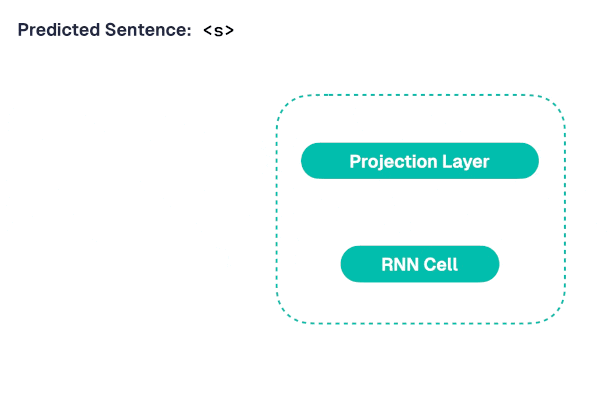

# Table of Contents

### [Goal of this Lab](#section:goal)

### [Preliminaries](#section:preliminaries)

### [Part 0. Playing with vectors](#section:part0)

* #### [Flatten](#section:flatten)
* #### [Squeeze/Unsqueeze](#section:squeeze)
* #### [Stack](#section:stack)
* #### [Split](#section:split)
* #### [Chunk](#section:chunk)
* #### [Cat](#section:cat)


### [Part 1. Using HF Datasets](#section:part1)

* #### [Downloading _Shakespeare's Sonnets_ from HF](#section:dataset)
* #### [Creating a tokenizer](#section:tokenizer)
* #### [Tokenizing a dataset](#section:tokenizing)


### [Part 2. Build the language model](#section:part2)

* #### [Planning the model](#section:planning)
* #### [Building a skeleton](#section:skeleton)
* #### [Implementing a language model](#section:implementing)

### [Part 3. Training the model](#section:training)

### [Part 4. Performing inference](#section:inference)



<u>**What we are doing in this lab**</u>


Our goal in this lab is to gain a intuitive understanding of how autoregressive sequence modelling works, from raw text to model implementation and performing inference. By the end, you'll have a stronger understanding of how to plan, build, train, and use language models.

This lab is divided into five parts, begining with a reminder of how vector manipulations tools work, followed by the parts focusing on a crucial aspect of model development:

**Part 0** shows you how to play with vectors so you can prepare them for the dimensions required by different parts of the model.

Understanding how to manipulate tensor shapes is essential for feeding data into neural networks correctly. This section introduces key PyTorch functions to reshape, combine, and split tensors.

**Part 1** covers how you can prepare your raw text data for language modelling.

- Create your own dataset using HF Datasets from raw text
- Implement and train a tokenizer tailored to your data
- Compare the output of various tokenization algorithms
- Visualise what batching tokens actually does

**Part 2** has you building an language model from scratch using RNN cells.

- Implement the core components of a sequence model
- Design the forward pass to predict logits for each token in the sequence
- Compute the loss between predicted outputs and target outputs
- Get hands on experience with the nuances and caveats you will only discover from doing it (e.g., shapes)

**Part 3** covers using HF to effciently train the model.

No more building your own training loop and hoping you got it right!

- Use HF's Trainer instead of building a training loop
- Experiment with hyperparameters
- Experience the effects of hyperparameters on improving training speed

**Part 4** requires you to make your model predict one word at a time.

Training a model is not the same as performing inference.

- Implement the core part of the greedy decoding algorithm
- Understand the differences between training and inference in autoregressive models



<u>**What we are not going to do**</u>

We are not going to be training on big data. _But if you get to the end, you can give it a go and see._

<a name="section:preliminaries"></a>

# Preliminaries

<small><i>We just need to install some packages but we're not going to import them until we need them.</i></small>

In [ ]:
!pip install transformers tokenizers rich ipytest hypothesis ipdb
!pip install -U datasets

In [ ]:
import ipytest
import torch
ipytest.autoconfig()

<a name="section:part0"></a>

# Part 0. Playing with Tensors

This part focuses on different tools to change the dimensionality of tensors. Sometimes, reshaping or reformatting vectors is necessary to match the input requirements of specific model layers. PyTorch offers a set of tensor operations that help you manipulate vector shapes with ease.


<a name="section:flatten"></a>

## Flatten

This methods collapses all the dimensions of the tensor into one single dimension starting with the start dimension and ending with the ending dimension.

So for example:

In [ ]:
hidden_states = torch.randn(32, 300, 4096) # (batch_size, seq_length, hidden_state)
print("flatten with start_dim=1: {}".format(hidden_states.flatten(start_dim=1).shape)) # -> returns: (32, 300 * 4096)

# We can even collapse all the dimensions into one dimension
print("flatten with no arguments: {}".format(hidden_states.flatten().shape)) # -> returns: (32 * 300 * 4096)

# You could select a slice to reduce the dimensions for
print("flatten with start_dim and end_dim: {}".format(
    hidden_states.flatten(start_dim=0, end_dim=1).shape
)) # -> returns: (32 * 300, 4096)

flatten with start_dim=1: torch.Size([32, 1228800])
flatten with no arguments: torch.Size([39321600])
flatten with start_dim and end_dim: torch.Size([9600, 4096])


Flatten returns a view so the process costs nothing. It is very useful for quick dimension reduction. For instance if you want to prepare your multi-dimensional tensor for an MLP head.

<a name="section:squeeze"></a>

## Squeeze/Unsqueeze

Unsqueeze helps us add a dimension to the vector while squeeze helps us reduce a dimension.

> Note: The different between flatten and squeeze is that squeeze only removes dimensions of 1 to avoid shape surprises

See the following examples:


In [ ]:
# 1. Add batch dimension to a vector
tensor = torch.randn(300, 4096)   #(seq_length, hidden_dim)
batched_tensor = tensor.unsqueeze(0)
print("batched_tensor shape: {}".format(batched_tensor.shape))
print("-----------------")

# 2. Time-series vector processing -> add a sequence length to the vector for RNNs
vector = torch.randn(3, 4096)   #(batch, hidden_dim)
seq_vec = vector.unsqueeze(1)
print("seq_vec shape: {}".format(seq_vec.shape))

batched_tensor shape: torch.Size([1, 300, 4096])
-----------------
seq_vec shape: torch.Size([3, 1, 4096])


In [ ]:
# 1. Remove batch dim from a vector after classication
batched_tensor = torch.randn(1, 300, 4096)   #(batch, seq_length, hidden_dim)
tensor = batched_tensor.squeeze(0)
print("tensor shape: {}".format(tensor.shape))
print("-----------------")

# 2. Remove sequence length when seq_length=1
seq_vec = torch.randn(3, 1, 4096)   #(batch, seq_length, hidden_dim)
vector = seq_vec.squeeze(1)
print("vector shape: {}".format(vector.shape))

tensor shape: torch.Size([300, 4096])
-----------------
vector shape: torch.Size([3, 4096])


You will be using Squeeze and Unsqueeze a lot when dealing with models. Sepcifically when different models deal with different input shapes!

<a name="section:stack"></a>

## Stack

Stacking, as the name suggests, helps put together different tensors into one tensor on the specified dimension. Lets say we want to create a batch of tesnors each with (300, 4096) dimensions. We can stack them together at the first dimension or maybe we have processed tokens with an RNN and we want to stack them together to create the sequence at the second dimension.

Below you can find some examples and use cases for this method.

In [ ]:
# 1. stack a batch of vectors
tensors = [torch.randn(300, 4096) for _ in range(32)] # (seq_length, hidden_dim)
batch = torch.stack(tensors)
print("batch shape: {}".format(batch.shape))
print("-----------------")

# 2. stack on the second dimension (e.g., creating the sequence dimension from rnn hidden states)
token_hs = [torch.randn(32, 4096) for _ in range(16)] # (batch_size, hidden_dim) each
sequence = torch.stack(token_hs, dim=1)
print("sequence shape: {}".format(sequence.shape))

batch shape: torch.Size([32, 300, 4096])
-----------------
sequence shape: torch.Size([32, 16, 4096])


<a name="section:split"></a>

## Split

This partitions vectors into equal chunks, mainly used for creating mini-batches, splitting sequences, ...

Below are some of the examples:

In [ ]:
# 1. create mini-batches from a batch
batch = torch.randn(32, 300, 4096) # (batch_size, seq_length, hidden_dim)
mini_batches = torch.split(batch, 4)
print("mini_batches length: {}".format(len(mini_batches)))
print("mini_batches[0] shape: {}".format(mini_batches[0].shape))
print("-----------------")

# 2. split sequences into 1-token vectors
sequence = torch.randn(32, 16, 4096) # (batch_size, seq_length, hidden_dim)
token_hs = torch.split(sequence, 1, dim=1)
print("token_hs length: {}".format(len(token_hs)))
print("token_hs[0] shape: {}".format(token_hs[0].shape))
print("-----------------")

# 3. split a vector into different sizes
vector = torch.randn(10)
splits = torch.split(vector, [1, 3, 6])
for i in range(len(splits)):
  print("split {} shape: {}".format(i, splits[i].shape))

mini_batches length: 8
mini_batches[0] shape: torch.Size([4, 300, 4096])
-----------------
token_hs length: 16
token_hs[0] shape: torch.Size([32, 1, 4096])
-----------------
split 0 shape: torch.Size([1])
split 1 shape: torch.Size([3])
split 2 shape: torch.Size([6])


<a name="section:chunk"></a>

## Chunk

Very similar to split, this tool is also responsible for partitioning tensors. However, the difference between split and chunk is that torch.size can do precision partitioning allowing us to partition into different segment sizes, while chunk let us split into equal partitions (almost!)

> Note: When the size of the chosen dimension is not perfectly divisible by chunks, this method adds extra elements to make up for it: torch.chunk(torch.arange(10), 3) yields sizes [4, 4, 2]







In [ ]:
# 1. split features for 8 attention heads (later on you will learn what attention is)
seq = torch.randn(32, 16, 4096) # (batch_size, seq_length, hidden_dim)
chunks = torch.chunk(seq, 8, dim=-1)
print("chunks[0] shape: {}".format(chunks[0].shape))
print("-----------------")

# 2. split a 10 dimensional vector into sizes of 3
vector = torch.randn(10)
chunks = torch.chunk(vector, 3)
for i in range(len(chunks)):
  print("chunk {} shape: {}".format(i, chunks[i].shape))

chunks[0] shape: torch.Size([32, 16, 512])
-----------------
chunk 0 shape: torch.Size([4])
chunk 1 shape: torch.Size([4])
chunk 2 shape: torch.Size([2])


<a name="section:cat"></a>

## Cat

Useful for concatenating the chunks back together on the specified dimension. Remember that the tensors should have matching dimensions except for the dimension to be concatenated.

> Note: cat creates a new tensor (unlike flatten), so large concatenations cost memory.

> Note 2: if you want to add a new axis, use torch.stack!


In [ ]:
# 1. combine the attention head outputs
chunks = [torch.randn(32, 16, 512) for _ in range(8)] # (batch_size, seq_length, hidden_dim)
seq = torch.cat(chunks, dim=-1)
print("seq shape: {}".format(seq.shape))
print("-----------------")

# 2. combine the feature column with different dimensions
tensor1 = torch.randn(32, 54)
tensor2 = torch.randn(32, 10)
tensor = torch.cat([tensor1, tensor2], dim=-1)
print("tensor shape: {}".format(tensor.shape))
print("-----------------")

# 3. combine mini-batches into one batch
mini_batches = [torch.randn(4, 300, 4096) for _ in range(8)] # (batch_size, seq_length, hidden_dim)
batch = torch.cat(mini_batches, dim=0)
print("batch shape: {}".format(batch.shape))

seq shape: torch.Size([32, 16, 4096])
-----------------
vector shape: torch.Size([32, 64])
-----------------
batch shape: torch.Size([32, 300, 4096])


<a name="section:argmax"></a>

## Argmax

It is really useful to return the index of the maximum within a vector. Usually used for class predictions or even next token prediction, which you will learn more about through the labs.

In [ ]:
# When we have a vector of logits and we want to predict one class for each
logits = torch.randn(32, 10) # (batch_size, num_classes)
predictions = torch.argmax(logits, dim=-1) # returns: the index of the max number in each vector
print("predictions: {}".format(predictions))
print("predictions shape: {}".format(predictions.shape))

predictions: tensor([2, 6, 6, 7, 1, 0, 8, 7, 4, 6, 9, 1, 4, 6, 0, 5, 1, 9, 0, 6, 8, 7, 8, 6,
        6, 3, 9, 9, 9, 5, 9, 2])
predictions shape: torch.Size([32])


<a name="section:part1"></a>

# Part 1. Using HF Datasets

As you saw in Lab 0, text needs to be converted into "tokens": unique IDs that refer to parts of the text. In this lab, we're going to be offloading all of the manual work and using HF for all its good stuff.


<a name="section:dataset"></a>

## Download _Shakespeare's Sonnets_ from HF

First up, we're going to use [Shakespeare's Sonnets](https://huggingface.co/datasets/kkawamu1/shakespeares_sonnets) as our dataset.

To access the dataset, we're going to use [Datasets from Hugging Face](https://huggingface.co/docs/datasets/main/en/index) since it is performant and a good thing to learn about for the long run.

Some answers to some questions you might have about this:

1. **Why not just use a DataFrame?**
    
    Performance when you start to scale up. It's also easier to save and load, and you can easily move from pandas to Datasets and back again.

2. **Why not just use a list of dictionaries?**

    Performance and memory usage. Datasets is much more efficient.


In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    "kkawamu1/shakespeares_sonnets",
    split="train"
    )


<a name="section:tokenizer"></a>

## Create a tokenizer

For an implementation of how to train a tokenizer (see Lab 0).

In [ ]:
# @title How to implement a word-level tokenizer with Hugging Face

from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers
from tokenizers.processors import TemplateProcessing
from transformers import PreTrainedTokenizerFast


def train_word_level_tokenizer(
    *,
    sentences: list[str],
    unk_token: str = "[UNK]",  # noqa: S107
    pad_token: str = "[PAD]",  # noqa: S107
    start_of_seq_token: str = "<s>",  # noqa: S107
    end_of_seq_token: str = "</s>",  # noqa: S107
) -> PreTrainedTokenizerFast:
    """Train a tokenizer on the sentences and return it.

    Args:
        sentences (list[str]): The sentences to train the tokenizer on.
    """
    # Create the trainer for the tokenizer, to train the tokenizer on the sentences.
    # IDs are dynamically grabbed when building the post-processor because the tokenizer isn't
    # trained yet.
    special_tokens = [unk_token, pad_token, start_of_seq_token, end_of_seq_token]
    trainer = trainers.WordLevelTrainer(
        special_tokens=special_tokens, show_progress=True
    )

    # Create the tokenizer model: use the WordLevel one to train each word as unique
    tokenizer = Tokenizer(models.WordLevel(unk_token=unk_token))  # noqa: S106

    # Normalise each sentence: using NFD unicode normalisation and stripping whitespace
    tokenizer.normalizer = normalizers.Sequence(
        [normalizers.NFD(), normalizers.Strip()]
    )

    # Tell the tokenizer how to split each input sentence. We're going to use the Whitespace which
    # will just split the sentence for each word.
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    # Set the template so it we have special tokens at the start and end of each sentence when
    # tokenising. This is so that for the end of the sentence, the model will learn that a special
    # token goes at the end of the predictions so it can stop predicting after that.
    tokenizer.post_processor = TemplateProcessing(
        single=f"{start_of_seq_token} $A {end_of_seq_token}",
        special_tokens=[
            (start_of_seq_token, special_tokens.index(start_of_seq_token)),
            (end_of_seq_token, special_tokens.index(end_of_seq_token)),
        ],
    )

    # And now we train the tokenizer on the sentenecs using the trainer. This can take a while if
    # you have loads of sentences, but this will be quick since we have 5.
    tokenizer.train_from_iterator(sentences, trainer=trainer)

    # Enable padding for the tokenizer.
    # The padding token is another special one that we use because when providing a batch of
    # sentences, the tokenizer can automaticlly pad the sentences to the same length so you don't
    # need to do this manually.
    tokenizer.enable_padding(
        pad_id=special_tokens.index(pad_token), pad_token=pad_token
    )

    # Wrap it in a `PreTrainedTokenizerFast` so that we can use it with transformers
    pretrained_tokenizer = PreTrainedTokenizerFast(
        bos_token=start_of_seq_token,
        eos_token=end_of_seq_token,
        unk_token=unk_token,
        pad_token=pad_token,
        clean_up_tokenization_spaces=True,
        tokenizer_object=tokenizer,
    )
    return pretrained_tokenizer


# Train the tokenizer on the sentences
word_level_tokenizer = train_word_level_tokenizer(sentences=dataset['text'])

# Encode a sentence and print the token ids
print(
    word_level_tokenizer.backend_tokenizer.encode("From fairest creatures we desire").tokens,
    word_level_tokenizer.backend_tokenizer.encode("From fairest creatures we desire").ids,
)


# Aside: using the below commented-out line resulted in the tokenize no longer padding the examples.
# I don't understand it either because it wasn't happening when I originally made this notebook.
# print(word_level_tokenizer("The thief stole."))


<a name="section:tokenizing"></a>

## Tokenize the dataset


Now you have a dataset of texts (i.e. [the sonnets](https://huggingface.co/datasets/kkawamu1/shakespeares_sonnets)) and a tokenizer, you need to combine them to create a dataset of tokenized sentences.

Doing this up front is useful for faster training later, and also that the inputs of the model are not going to be changing so much. HF Datasets gives us a very nice and quick way to tokenize the dataset, which you see below.

This is what [HF recommend](https://huggingface.co/docs/datasets/en/use_dataset#tokenize-text), so don't fear the lambda (/anonymous function).



In [ ]:
tokenized_dataset = dataset.map(
    lambda example: {"input_ids": word_level_tokenizer.encode(example["text"])}
)

# (The below is done just so colab pretty prints the dataset for us)
tokenized_dataset.to_pandas()


<a name="section:part2"></a>

# Part 2. Build the language model


We're going to implement a **sequence-based language model** that takes each word of a sentence as input and **predicts the next one**.








<a name="section:planning"></a>

## Planning the model

There are three main components to this model:

1. Embedding token IDs (to dense representations)
2. _"Generate a hidden state of the sentence up to that point"_
3. Classifying the hidden state at each step to some token (from the list in our vocabulary)

In Lab 1, you've learned about training an embedding layer using `torch.nn.Embedding` and also classifiying that hidden state into a probability distribution (i.e., logits) using `torch.nn.Linear`. That leaves the middle/2nd aspect.

You've now seen RNNs and recurrent layers, so we're going to be using those to do the sequence modelling!

Again, refer to the below *illustration* for what's happening in the sequence model,  including how inputs and hidden states turn into outputs.

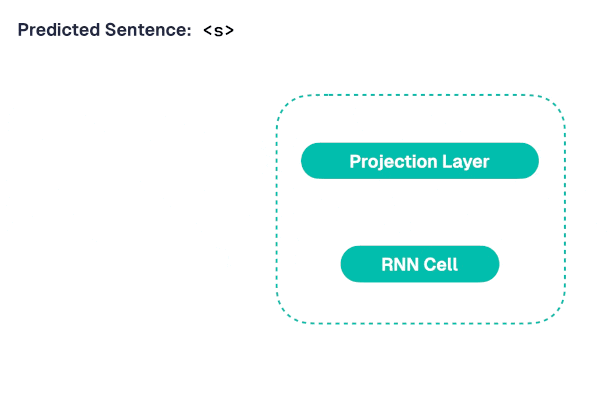

<a name="section:skeleton"></a>

## Building a skeleton

Before implementing, it's worth just planning out the steps to make sure we are modelling what we think we are modelling.

Within a `torch.nn.Module`, you need to implement two methods: the `__init__` and the `forward`. The `__init__` construct the pieces you need, and the forward has the logic of the actual model.

Before you know what pieces you need, you need to understand how the pieces are going to fit together. That means **first figuring out the inputs and outputs of the `forward`,** and then figuring out the pieces you need to make that happen.

Currently, our skeleton looks like this. We know that there needs to be an `__init__` and that there's going to be some stuff in it.

```python
class LanguageModel(torch.nn.Module):
    def __init__(self, ...) -> None:
        super().__init__()
        ...
```

### What are the inputs and outputs of the forward?

The **inputs are the token IDs of the sentences**. That means we are giving the model an input with a shape of `(batch_size, sequence_length)`. And some of these tokens are going to be the padded tokens too.

At the end, we want to be able to **return the logits** of the next word in the sentence: the probability distribution of the next word. That means we are going to return a tensor with a shape of `(batch_size, sequence_length, vocab_size)`.
Alongside that, we also want to be able to **return some loss metric**: a scalar value that indicates how well the model has predicted the next word. The loss is computed by comparing the logits predicted by the model to the actual next word in the sentence.



model high level.svg


Taking the above, we are probably going to create a `forward` method that is going to look something like this:

```python
class LanguageModel(torch.nn.Module):
    def __init__(self, ...) -> None:
        super().__init__()
        ...

    def forward(self, input_ids: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        ...
```


### Breaking the forward up into steps

There are two main parts to the forward: predicting the logits and computing the loss. To make a  clean implementation method, we can break it down into the other methods:

1. `predict_logits` that takes the tokens and returns the logits
2. `compute_loss` that takes the predicted outputs, the target outputs, and computes the loss





If we take that put it into code, our skeleton is looking like this:

```python
class LanguageModel(torch.nn.Module):
    def __init__(self, ...) -> None:
        super().__init__()
        ...

    def forward(self, input_ids: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        logits = self.predict_logits(input_ids)
        loss = self.compute_loss(logits, input_ids)
        return loss, logits

    def predict_logits(self, input_ids: torch.Tensor) -> torch.Tensor:
        ...

    def compute_loss(self, logits: torch.Tensor, target_ids: torch.Tensor) -> torch.Tensor:
        ...
```

In our skeleton, the forward is essentially complete; there's no gaps. The gaps are now in the [individual methods which each have a clear purpose](https://en.wikipedia.org/wiki/Single-responsibility_principle) (yes, we are going to do some programming skills too!).


### Figuring out the components from the steps

Given the inputs and outputs, we can start to figure out what components we need to make this happen.

0. The model receives token IDs as a batch, in the shape `(batch_size, max sequence length)`
1. Convert these into a dense representation: *an embedding layer*
2. Provide the tokens at each timestep to an RNN cell *one at a time*, because we are working with sequences
3. Keep track of the output hidden state from each token
4. "Stack" the hidden states back together for the entire sequence
5. Pass the output hidden state from each RNN step through a projection layer to get the logits.
6. Compute the loss by comparing the logits to the actual *next word in the sentence*
7. Return the logits and the loss

If we look at this from a high-level, it'll look like this:


forward 2.svg

This tells us that we need the following components:

1. An embedding layer—`torch.nn.Embedding`
2. An RNN layer: `torch.nn.LSTMCell` or `torch.nn.GRUCell` or `torch.nn.RNNCell`
3. A projection layer—`torch.nn.Linear`
4. A loss function—`torch.nn.CrossEntropyLoss`

We don't need to bother with activation functions or things like that since they are already included in the RNN and the loss function.

Alright, ready to go?

##### **But wait, there's more... caveats to consider!**

We are providing a batch of sentences to the model as tokens, and the RNN Cell should only be receiving one "timestep"/token at a time to predict the next one. That means that we need to "chunk" or "split"<sup>*hint hint*</sup> the embedded inputs so that each one of the "chunks"<sup>*hint*</sup> has the shape `(batch_size, embedding_dim)`.

***Also***, we need to store the hidden state that is output after each timestep too so we can combine or "stack"<small><sup>*hint*</sup></small> them back together into the shape `(batch_size, sequence_length, embedding_dim)`.




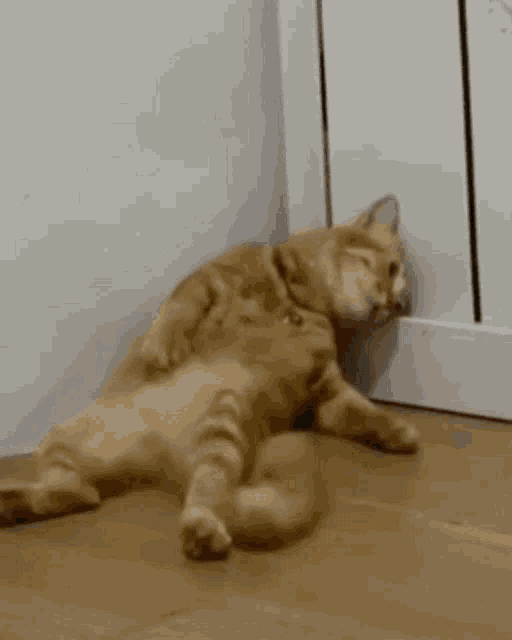
</br><sup>You, after all the words, probably</sup>



<a name="section:implementing"></a>

## Implementing a language model

As a result of all the stuff we've covered above, we can construct a skeleton of the model we're about to implement. To make that easier, we've written a simple skeleton of the model that you can start with but you need to fill it all in.

You've got signatures for classes, docstrings, and everything you should need. The rest is up to you.

**And remember:** We are around to help, ask us if you are stuck or unsure!



In [ ]:
# @title **[Task]** Implement the language model

from typing import Any

import torch
from transformers.modeling_outputs import ModelOutput
from dataclasses import dataclass

@dataclass
class LanguageModelOutput(ModelOutput):
    """Output from the RNN model."""

    loss: torch.Tensor
    logits: torch.Tensor | None = None


class LanguageModel(torch.nn.Module):
    """Simple language model using recurrent layers."""

    def __init__(
        self,
        *,
        vocab_size: int,
        embedding_dim: int,
        padding_token_id: int,
        rnn_cell: torch.nn.RNNCell | torch.nn.LSTMCell | torch.nn.GRUCell,
        dropout: float = 0,
    ) -> None:
        # Don't forget this now
        super().__init__()

        # Tips:
        # 1. There is a reason the RNN is provided and not built inside this class.
        # 2. You can get the hidden size from any rnn cell in torch using the `hidden_size` attribute
        # 3. Consider why the padding token ID is being given in the init.
        raise NotImplementedError


    def forward(self, input_ids: torch.Tensor, **kwargs: Any) -> LanguageModelOutput:  # noqa: ARG002
        """Forward pass of the model.

        Args:
            input_ids: torch.Tensor, shape [batch_size, seq_len]
            kwargs: Additional arguments that are ignored

        Returns:
            logits: torch.Tensor, shape [batch_size, seq_len, vocab_size]
            loss: torch.Tensor, scalar
        """
        logits = self.predict_logits(input_ids)
        loss = self.compute_loss(logits, input_ids)

        return LanguageModelOutput(loss=loss, logits=logits)

    def predict_logits(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Predict logits for the given input.

        Args:
            input_ids: torch.Tensor, shape [batch_size, seq_len]

        Returns:
            logits: torch.Tensor, shape [batch_size, seq_len, vocab_size]
        """
        # Embed the inputs
        # Shape: [batch_size, seq_len, dim]

        # Split the inputs into individual timesteps
        # Shape: list[batch_size, dim]

        # Prepare a list to store all the hidden states

        # Create the initial hidden state of zeros
        # Shape: [batch_size, dim]

        # Encode each token/step into the rnn cell and store the output in the list

        # Stack the outputs into a single tensor
        # Shape: [batch_size, seq_len, dim]

        # Add some dropout
        # Shape: [batch_size, seq_len, dim]

        # Project to logits
        # Shape: [batch_size, seq_len, dim]
        raise NotImplementedError

    def compute_loss(self, logits: torch.Tensor, input_ids: torch.Tensor) -> torch.Tensor:
        """Compute the loss for the given logits and input_ids.

        Args:
            logits: torch.Tensor, shape [batch_size, seq_len, vocab_size]
            input_ids: torch.Tensor, shape [batch_size, seq_len]

        Returns:
            loss: torch.Tensor, scalar
        """
        # We need to slice/view the logits and input ids tensors a bit
        # since we are doing a language modeling task that computes an autoregressive loss

        # Provide the values to a loss function
        raise NotImplementedError

In [ ]:
# @title Unit tests to check your implementation

%%ipytest -vv --capture=tee-sys -p no:warnings

import pytest
from hypothesis import given, strategies as st, assume, settings, HealthCheck

_VOCAB_SIZE = 20


@pytest.fixture(scope="session")
def padding_token_id() -> int:
    return 3


@pytest.fixture(scope="session")
def vocab_size() -> int:
    return _VOCAB_SIZE


@pytest.fixture(scope="session")
def embedding_dim() -> int:
    return 32


@pytest.fixture(scope="session")
def model(embedding_dim: int, padding_token_id: int, vocab_size: int) -> LanguageModel:
    return LanguageModel(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        padding_token_id=padding_token_id,
        rnn_cell=torch.nn.RNNCell(input_size=embedding_dim, hidden_size=embedding_dim),
        dropout=0,
    )


def test_instantiating_model_does_not_error(embedding_dim: int) -> None:
    model = LanguageModel(
        vocab_size=20,
        embedding_dim=embedding_dim,
        padding_token_id=3,
        rnn_cell=torch.nn.RNNCell(input_size=embedding_dim, hidden_size=embedding_dim),
        dropout=0,
    )


@given(
    dummy_input_ids=st.lists(
        st.lists(st.integers(min_value=0, max_value=_VOCAB_SIZE - 1), min_size=1),
        min_size=1,
    )
)
def test_predict_logits_output_shapes_are_correct(
    model: LanguageModel, dummy_input_ids: list[list[int]], padding_token_id: int
) -> None:
    dummy_input_tensor = torch.nn.utils.rnn.pad_sequence(
        [torch.Tensor(dummy_ids) for dummy_ids in dummy_input_ids],
        batch_first=True,
        padding_value=padding_token_id,
    ).to(torch.long)
    logits = model.predict_logits(dummy_input_tensor)

    # check batch size
    assert logits.size(0) == dummy_input_tensor.size(0)
    # check seq length
    assert logits.size(1) == dummy_input_tensor.size(1)
    # check logit size
    assert logits.size(2) == _VOCAB_SIZE


@given(
    dummy_input_ids=st.lists(
        st.lists(st.integers(min_value=0, max_value=_VOCAB_SIZE - 1), min_size=2),
        min_size=1,
    )
)
@settings(suppress_health_check=[HealthCheck.filter_too_much])
def test_loss_works_correctly(model: LanguageModel, dummy_input_ids: list[list[int]], padding_token_id: int) -> None:
    targets = torch.nn.utils.rnn.pad_sequence([torch.tensor(input_ids) for input_ids in dummy_input_ids], batch_first=True, padding_value=3).to(torch.long)
    assume(targets.eq(padding_token_id).logical_not().sum(dim=-1).gt(1).all())
    logits = torch.randn(targets.size(0), targets.size(1), targets.max() + 1)
    logits.scatter_add_(dim=2, index=targets[:, 1:].unsqueeze(-1), src=torch.full_like(logits, fill_value=100))
    loss = model.compute_loss(logits, targets)
    assert loss < 0.01

<a name="section:training"></a>

# Part 3. Building the training loop

Once you've built the module, now you have to train it and make sure it works. You _could_ build your own training loop (as you saw yesterday), or we can take advantage of someone else having done the work for us!

Below, we use the Trainer from the Transformers library to do the training. We just have to make sure our model [follows some rules](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/trainer#trainer) (which it does as the `forward` returns a dataclass that was subclassed from `ModelOutput`).


Just check the code below and see what we did.

**Reference links**

- [HF Trainer guide](https://huggingface.co/docs/transformers/trainer)
- [HF Trainer API](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/trainer#trainer)




In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

EMBEDDING_DIM = 16
DROPOUT = 0.5

# Instantiate the model
model = LanguageModel(
    vocab_size=word_level_tokenizer.vocab_size,
    embedding_dim=EMBEDDING_DIM,
    padding_token_id=word_level_tokenizer.pad_token_id,
    rnn_cell = torch.nn.RNNCell(
        input_size=EMBEDDING_DIM, hidden_size=EMBEDDING_DIM
    ),
    dropout=DROPOUT,
)

# Instantiate the training and its arguments
training_args = TrainingArguments(
    # Hyperparameters
    learning_rate=0.05,
    per_device_train_batch_size=5,
    num_train_epochs=10,
    weight_decay=0.5,
    max_grad_norm=400,
    # Other things to log outputs
    output_dir="your-model",
    logging_steps=10,
    report_to="none",
)

# Build the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
    tokenizer=word_level_tokenizer,
)

# Do the training
trainer.train()


## Debugging your model

If your loss is not going down, then there's likely a bug _somewhere:_ maybe in the code itself, or poor hyperparameter choices; it's hard to know immediately.

Given that models tend to be a black box, the first thing to do is **make sure that the model is learning.** Create a dataset of a single example and feed that into the model with a generous learning rate and 100s/1000s of epochs. If the loss goes down, your model _can_ learn and your gradient flow is good.

Then, start to **introduce examples back into the dataset _slowly_ and see where it breaks.** There might be a problem/bug/inconsistency with a single example causing the learning to go wild. If this happens, use ipdb (or other debugging tools) to add breakpoints and inspect the tensors/variables manually.

Once you know it works, try **changing hyperparameters** and see how that affects learning.

## [Task] How fast can you make the model converge?

Adjust the hyperparameters to make the model converge---with a loss below 0.25---in **as few epochs as possible**.


Here are just _some_ hyperparameters you could try:

- Embedding Size
- Dropout
- Learning Rate
- Batch size
- Num train epochs
- Weight decay
- RNN cell (RNN, LSTM, GRU)
- Tokenizer (Word Level, WordPiece, BPE, etc.)



Try and answer the following questions:

1. How many epochs did it take to converge?
2. What was the smallest loss you achieved?
3. What was your best set of parameters?

<small>*Hint: There's multiple ways to address this: manually checking each combination, using a for loop with some if statements, and/or using early stopping. Feel free to try whatever you want!*<small>

<a name="section:inference"></a>

# Part 4. Performing inference

So far, all we did was train the model to be able to do the task. Now, we need to be able to give the model some words to start it off, and then let it keep predicting.

Below is a the familiar by now visualisation of autoregressive decoding and the implementation for greedy decoding that we've provided for you.

**Ideas to Try**

* Try to enter different input texts in the `text_input` field and see what it gets to produce. What happens when you provide just one word versus five or ten?

* Ask the model to generate a larger number of tokens when you call `do_greedy_decoding_from_token_ids()`.

* Go back to the training script and train a model for **fewer** steps. What happens to the output now?


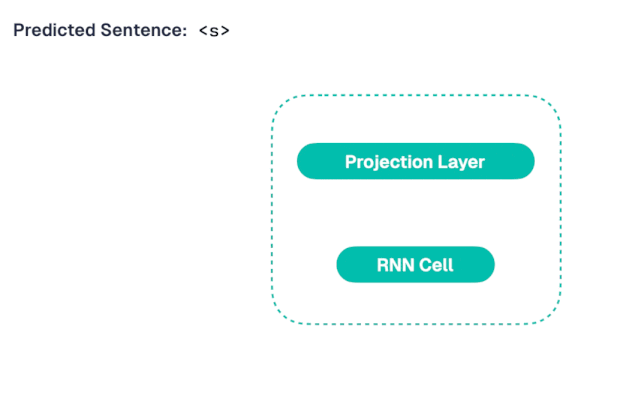

In [ ]:
  # @title Greedy decoding {"run":"auto","vertical-output":true,"form-width":"40%"}
# @markdown
# @markdown You can use the below form to easily try out different text inputs.

import torch


@torch.inference_mode()
def prepare_tokens_ids_for_greedy_decoding(
    token_ids: torch.Tensor, *, bos_token_id: int
) -> torch.Tensor:
    """Prepare the tokens for greedy decoding.

    The returned tensor needs to satisfy these conditions:
        1. Must be 2-dimensional; (batch_size, seq_len) with batch_size == 1
        2. Must start with BOS token if it doesn't
    """
    # If there are no tokens in the token_ids; e.g., tokenized empty string
    if token_ids.numel() == 0:
        # Create a tensor with only BOS tokens, with a seq len of 1
        token_ids = torch.full(
            (1, 1), fill_value=bos_token_id, dtype=torch.long, device=token_ids.device
        )

    # If the token_ids don't already start with the BOS token, prepend it in
    if token_ids[:, 0] != bos_token_id:
        token_ids = torch.cat(
            [
                torch.full(
                    (1, 1),
                    fill_value=bos_token_id,
                    dtype=torch.long,
                    device=token_ids.device,
                ),
                token_ids,
            ],
            dim=-1,
        )

    assert token_ids.ndim == 2
    assert token_ids.size(0) == 1
    return token_ids


@torch.inference_mode()
def do_greedy_decoding_from_token_ids(
    token_ids: torch.Tensor,
    *,
    model: LanguageModel,
    eos_token_id: int,
    max_tokens_to_generate: int = 30,
) -> torch.Tensor:
    """Do greedy decoding from token IDs."""
    predictions = token_ids

    for _ in range(1, max_tokens_to_generate):
        # 1. Get the logits for the next token using the currently predicted tokens
        logits = model.predict_logits(predictions)

        # 2. Slice the tensor to just get the token we predicted since the model predicts more
        #    than one token at a time
        logits_for_next_token = logits[:, -1]

        # 3. Get the token with the highest likelihood using the logits
        predicted_token = logits_for_next_token.argmax(dim=-1)

        # 4. Append the token to the predictions
        predictions = torch.cat([predictions, predicted_token.unsqueeze(-1)], dim=-1)

        # 5. If the predicted token is the end of sequence token, break out the loop
        if predicted_token.item() == eos_token_id:
            break

    return predictions


tokenizer = word_level_tokenizer # @param {type: "raw"}

# Figure out the text input you're starting the model off with
text_input = "From fairest creatures we"  # @param {type: "string"}
print("Text input: ", text_input)

# Encode the text input and turn it into a tensor
token_ids = tokenizer.encode(
    text_input, return_tensors="pt", add_special_tokens=False
).to(training_args.device)
print("Token IDs: ", token_ids)

# Prepare the tokens for greedy decoding
token_ids = prepare_tokens_ids_for_greedy_decoding(
    token_ids, bos_token_id=tokenizer.bos_token_id
)
print("Prepared token IDs: ", token_ids)

# Do the greedy decoding
predictions = do_greedy_decoding_from_token_ids(
    token_ids, model=trainer.model, eos_token_id=tokenizer.eos_token_id
)
print("Predicted tokens: ", predictions)

# Convert the predicted tensor back to text
decoded_predictions = tokenizer.decode(predictions[0])
print("Predicted output: ", decoded_predictions)


NameError: name 'LanguageModel' is not defined